In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.optim as optim

from utils import load_data,normalize,toy_data,norm_embed,nmi_score

import matplotlib.pyplot as plt 

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from layers import GraphConvolution, InnerProduct
from utils import norm_embed
import torch

In [3]:
class GNN(nn.Module):
    
    def __init__(self, batch_size, nfeat, nhid, ndim):
        super(GNN, self).__init__()

        self.gc1 = GraphConvolution(batch_size, nfeat, nhid)
        self.embeddings = GraphConvolution(batch_size, nhid, 2*ndim)
        self.reconstructions = InnerProduct(2*ndim)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = self.embeddings(x, adj)
        x = norm_embed(x)
        mu = F.relu(self.reconstructions(x))
        return mu
    

In [4]:
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False,precision=8)

In [5]:
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--seed', type=int, default=426, help='Random seed.')
parser.add_argument('--epochs', type=int, default=5000,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=10e-8,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--ndim', type=int, default=2,
                    help='Embeddings dimension.')

args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [6]:
if 1:
    # Taxi Dataset Graph
    adj = load_data()
    #adj = load_data(daily=True)
else:
    #Toy Example Graph
    adj = toy_data()

In [7]:
def GraphNeuralNet(adj,dim):
    
    # Set the random seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
        
    args.ndim = dim
    
    adj_norm = normalize(adj)

    adj = torch.FloatTensor(np.array(adj))
    adj_norm = torch.FloatTensor(np.array(adj_norm))

    # Model and optimizer
    model = GNN(batch_size=adj_norm.shape[0],
                nfeat=adj_norm.shape[1],
                nhid=args.hidden,
                ndim=args.ndim)

    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    model.embeddings.register_forward_hook(get_activation('embeddings'))


    optimizer = optim.Adam(model.parameters(),
                           lr=args.lr, weight_decay=args.weight_decay)



    features = torch.FloatTensor(torch.eye(adj.shape[1]))
    features = features.reshape((1,adj.shape[1],adj.shape[1]))
    features = features.repeat(adj.shape[0], 1, 1)

    if args.cuda:
        model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        adj_norm = adj_norm.cuda()


    # Train model
    t_total = time.time()
    A2norm = (adj_norm ** 2).mean()
    #A2norm = (adj_norm ** 2).view(adj_norm.shape[0],-1).mean(axis=1)
    
    losses = []

    for epoch in range(args.epochs):

        t = time.time()
        model.train()
        optimizer.zero_grad()
        mu = model(features, adj_norm)
        
        with torch.no_grad():
            mse = torch.nn.MSELoss()
            mseloss = mse(torch.flatten(mu),torch.flatten(adj_norm))
            sig = torch.sqrt(mseloss)
        sigma = sig * torch.ones(adj_norm.shape,requires_grad=True)
        
        # loss function
        criterion = torch.nn.GaussianNLLLoss()
        loss = criterion(torch.flatten(adj_norm), torch.flatten(mu), torch.flatten(sigma)) #/ A2norm
        loss.backward()
        optimizer.step()

        if epoch == 0:
            best_loss = loss
        else:
            if loss < best_loss:
                best_loss = loss

        if epoch % 100 == 0:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'loss: {:.8f}'.format(best_loss.item()),
                  'time: {:.4f}s'.format(time.time() - t))
            
        losses.append(loss)

    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    
    return adj_norm,mu,losses


In [8]:
dim=1
adj_norm,mu,losses = GraphNeuralNet(adj=adj,dim=dim)

Epoch: 0001 loss: -2.28350091 time: 0.0000s
Epoch: 0101 loss: -2.33948970 time: 0.0080s
Epoch: 0201 loss: -2.33950472 time: 0.0000s
Epoch: 0301 loss: -2.33950663 time: 0.0080s
Epoch: 0401 loss: -2.33950734 time: 0.0000s
Epoch: 0501 loss: -2.33950758 time: 0.0000s
Epoch: 0601 loss: -2.33950782 time: 0.0000s
Epoch: 0701 loss: -2.33950806 time: 0.0000s
Epoch: 0801 loss: -2.33950806 time: 0.0080s
Epoch: 0901 loss: -2.33950830 time: 0.0000s
Epoch: 1001 loss: -2.33950830 time: 0.0000s
Epoch: 1101 loss: -2.33950830 time: 0.0000s
Epoch: 1201 loss: -2.33950877 time: 0.0019s
Epoch: 1301 loss: -2.33950877 time: 0.0000s
Epoch: 1401 loss: -2.33950877 time: 0.0000s
Epoch: 1501 loss: -2.33950877 time: 0.0080s
Epoch: 1601 loss: -2.33950877 time: 0.0000s
Epoch: 1701 loss: -2.33950877 time: 0.0000s
Epoch: 1801 loss: -2.33950877 time: 0.0000s
Epoch: 1901 loss: -2.33950877 time: 0.0080s
Epoch: 2001 loss: -2.33950877 time: 0.0000s
Epoch: 2101 loss: -2.33950877 time: 0.0000s
Epoch: 2201 loss: -2.33950877 ti

NMI Score : 0.10148830686294205


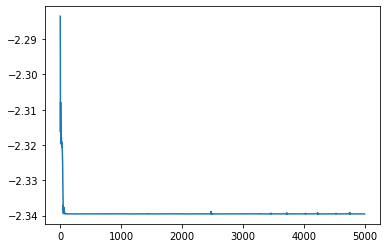

In [9]:
plt.plot(losses)
nmi = nmi_score(adj_norm[0],mu.reshape(adj_norm.shape[1:]).detach())
print("NMI Score : {}".format(nmi))

In [10]:
dim=2
adj_norm,mu,losses = GraphNeuralNet(adj=adj,dim=dim)

Epoch: 0001 loss: -2.28350401 time: 0.0040s
Epoch: 0101 loss: -2.39309621 time: 0.0040s
Epoch: 0201 loss: -2.40448833 time: 0.0040s
Epoch: 0301 loss: -2.40970778 time: 0.0030s
Epoch: 0401 loss: -2.41365290 time: 0.0030s
Epoch: 0501 loss: -2.41442108 time: 0.0050s
Epoch: 0601 loss: -2.41666293 time: 0.0040s
Epoch: 0701 loss: -2.41876054 time: 0.0040s
Epoch: 0801 loss: -2.41876054 time: 0.0040s
Epoch: 0901 loss: -2.41942906 time: 0.0030s
Epoch: 1001 loss: -2.42049456 time: 0.0030s
Epoch: 1101 loss: -2.42142701 time: 0.0020s
Epoch: 1201 loss: -2.42142701 time: 0.0040s
Epoch: 1301 loss: -2.42233849 time: 0.0030s
Epoch: 1401 loss: -2.42284632 time: 0.0040s
Epoch: 1501 loss: -2.42314434 time: 0.0030s
Epoch: 1601 loss: -2.42367744 time: 0.0040s
Epoch: 1701 loss: -2.42405295 time: 0.0030s
Epoch: 1801 loss: -2.42456722 time: 0.0030s
Epoch: 1901 loss: -2.42797065 time: 0.0030s
Epoch: 2001 loss: -2.43076444 time: 0.0040s
Epoch: 2101 loss: -2.43263221 time: 0.0030s
Epoch: 2201 loss: -2.43377185 ti

NMI Score : 0.7658681269221899


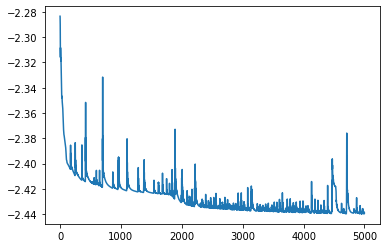

In [11]:
plt.plot(losses)
nmi = nmi_score(adj_norm[0],mu.reshape(adj_norm.shape[1:]).detach())
print("NMI Score : {}".format(nmi))

In [12]:
dim=3
adj_norm,mu,losses = GraphNeuralNet(adj=adj,dim=dim)

Epoch: 0001 loss: -2.28350282 time: 0.0050s
Epoch: 0101 loss: -2.45478320 time: 0.0060s
Epoch: 0201 loss: -2.48810029 time: 0.0060s
Epoch: 0301 loss: -2.49836445 time: 0.0030s
Epoch: 0401 loss: -2.49836445 time: 0.0060s
Epoch: 0501 loss: -2.49836445 time: 0.0060s
Epoch: 0601 loss: -2.50400233 time: 0.0060s
Epoch: 0701 loss: -2.52311993 time: 0.0060s
Epoch: 0801 loss: -2.53734303 time: 0.0030s
Epoch: 0901 loss: -2.54314971 time: 0.0060s
Epoch: 1001 loss: -2.54634166 time: 0.0060s
Epoch: 1101 loss: -2.54934311 time: 0.0030s
Epoch: 1201 loss: -2.55147600 time: 0.0060s
Epoch: 1301 loss: -2.55429459 time: 0.0041s
Epoch: 1401 loss: -2.55626106 time: 0.0040s
Epoch: 1501 loss: -2.55832958 time: 0.0040s
Epoch: 1601 loss: -2.55988455 time: 0.0040s
Epoch: 1701 loss: -2.55992436 time: 0.0040s
Epoch: 1801 loss: -2.56178832 time: 0.0040s
Epoch: 1901 loss: -2.56323957 time: 0.0040s
Epoch: 2001 loss: -2.56393337 time: 0.0080s
Epoch: 2101 loss: -2.56459737 time: 0.0040s
Epoch: 2201 loss: -2.56505275 ti

NMI Score : 0.7256382372295549


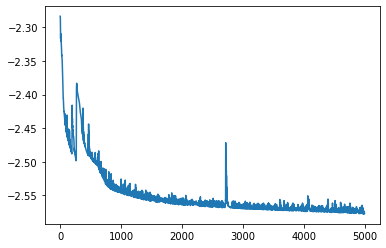

In [13]:
plt.plot(losses)
nmi = nmi_score(adj_norm[0],mu.reshape(adj_norm.shape[1:]).detach())
print("NMI Score : {}".format(nmi))

In [14]:
dim=4
adj_norm,mu,losses = GraphNeuralNet(adj=adj,dim=dim)

Epoch: 0001 loss: -2.28350091 time: 0.0040s
Epoch: 0101 loss: -2.50200987 time: 0.0040s
Epoch: 0201 loss: -2.60107255 time: 0.0040s
Epoch: 0301 loss: -2.63626528 time: 0.0040s
Epoch: 0401 loss: -2.65242624 time: 0.0040s
Epoch: 0501 loss: -2.66376662 time: 0.0040s
Epoch: 0601 loss: -2.67237639 time: 0.0040s
Epoch: 0701 loss: -2.67796469 time: 0.0040s
Epoch: 0801 loss: -2.68218637 time: 0.0040s
Epoch: 0901 loss: -2.68556166 time: 0.0040s
Epoch: 1001 loss: -2.69035077 time: 0.0040s
Epoch: 1101 loss: -2.69338417 time: 0.0040s
Epoch: 1201 loss: -2.69606423 time: 0.0040s
Epoch: 1301 loss: -2.69838142 time: 0.0080s
Epoch: 1401 loss: -2.69961023 time: 0.0040s
Epoch: 1501 loss: -2.70084023 time: 0.0040s
Epoch: 1601 loss: -2.70184803 time: 0.0040s
Epoch: 1701 loss: -2.70307541 time: 0.0040s
Epoch: 1801 loss: -2.70415664 time: 0.0080s
Epoch: 1901 loss: -2.70502043 time: 0.0040s
Epoch: 2001 loss: -2.70571065 time: 0.0080s
Epoch: 2101 loss: -2.70654368 time: 0.0040s
Epoch: 2201 loss: -2.70714426 ti

NMI Score : 0.7347108991055938


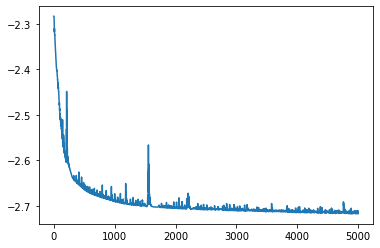

In [15]:
plt.plot(losses)
nmi = nmi_score(adj_norm[0],mu.reshape(adj_norm.shape[1:]).detach())
print("NMI Score : {}".format(nmi))